In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
from sklearn.svm import SVC
from numpy import mean
from numpy import std
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

warnings.filterwarnings(action="ignore")

In [2]:
import os
for dirname, _, filenames in os.walk('data_file.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Preprocessing

In [5]:
# Open the datasets:
df = pd.read_csv("data_file.csv")
# Delete the useless columns:
cols_to_drop = ['FileName', 'md5Hash']
df = df.drop(columns=cols_to_drop)
# Replace the value repeated: MD5HASH - DebugSize - MajorOSVersion - BitcoinAddresses - NumberOfSections - SizeOfStackReserve
columns = ["Machine", "DebugSize", "NumberOfSections", "SizeOfStackReserve", "MajorOSVersion", "BitcoinAddresses"]
for col in columns:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes
# Delete all the duplicated rows:
df.drop_duplicates(keep='last')
# Save the new datasets into a new csv file:
df.to_csv("df_clear.csv")

In [6]:
# Take a look at the data after processing
df = pd.read_csv("df_clear.csv")
df.head()

,Unnamed: 0,Machine,DebugSize,DebugRVA,MajorImageVersion,MajorOSVersion,ExportRVA,ExportSize,IatVRA,MajorLinkerVersion,MinorLinkerVersion,NumberOfSections,SizeOfStackReserve,DllCharacteristics,ResourceSize,BitcoinAddresses,Benign
0,0,1,0,0,0,4,0,0,8192,8,0,2,12,34112,672,0,1
1,1,4,11,121728,10,10,126576,4930,0,14,10,7,9,16864,1024,0,1
2,2,1,0,0,0,4,0,0,8192,8,0,2,12,34112,672,0,1
3,3,4,11,19904,10,10,21312,252,18160,14,10,5,9,16736,1040,0,1
4,4,4,11,97728,10,10,105792,1852,70592,14,10,6,9,16736,1096,0,1


In [7]:
# DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62485 entries, 0 to 62484
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Unnamed: 0          62485 non-null  int64
 1   Machine             62485 non-null  int64
 2   DebugSize           62485 non-null  int64
 3   DebugRVA            62485 non-null  int64
 4   MajorImageVersion   62485 non-null  int64
 5   MajorOSVersion      62485 non-null  int64
 6   ExportRVA           62485 non-null  int64
 7   ExportSize          62485 non-null  int64
 8   IatVRA              62485 non-null  int64
 9   MajorLinkerVersion  62485 non-null  int64
 10  MinorLinkerVersion  62485 non-null  int64
 11  NumberOfSections    62485 non-null  int64
 12  SizeOfStackReserve  62485 non-null  int64
 13  DllCharacteristics  62485 non-null  int64
 14  ResourceSize        62485 non-null  int64
 15  BitcoinAddresses    62485 non-null  int64
 16  Benign              62485 non-null  int6

In [8]:
# Describe dataframe
df.describe()

,Unnamed: 0,Machine,DebugSize,DebugRVA,MajorImageVersion,MajorOSVersion,ExportRVA,ExportSize,IatVRA,MajorLinkerVersion,MinorLinkerVersion,NumberOfSections,SizeOfStackReserve,DllCharacteristics,ResourceSize,BitcoinAddresses,Benign
count,62485.000000,62485.000000,62485.000000,6.248500e+04,62485.000000,62485.000000,6.248500e+04,6.248500e+04,6.248500e+04,62485.000000,62485.000000,62485.000000,62485.000000,62485.000000,6.248500e+04,62485.000000,62485.000000
mean,31242.000000,1.567464,3.486053,1.541611e+05,58.785997,5.409634,8.953186e+05,4.094623e+05,1.466311e+05,9.782604,6.613171,3.750676,10.967368,12966.031400,1.844664e+05,0.018004,0.433992
std,18038.010122,1.175653,4.422484,1.903142e+06,1114.068244,2.097013,3.779527e+07,2.851820e+07,1.124630e+06,9.047157,16.976465,2.132978,3.015878,15762.725511,1.732625e+07,0.132968,0.495628
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,15621.000000,1.000000,0.000000,0.000000e+00,0.000000,4.000000,0.000000e+00,0.000000e+00,4.096000e+03,6.000000,0.000000,2.000000,9.000000,0.000000,1.080000e+03,0.000000,0.000000
50%,31242.000000,1.000000,0.000000,0.000000e+00,0.000000,5.000000,0.000000e+00,0.000000e+00,8.520000e+03,9.000000,0.000000,4.000000,12.000000,320.000000,2.496000e+03,0.000000,0.000000
75%,46863.000000,1.000000,6.000000,1.283200e+04,6.000000,6.000000,2.875200e+04,1.040000e+02,6.553600e+04,11.000000,10.000000,5.000000,12.000000,32768.000000,2.350400e+04,0.000000,1.000000
max,62484.000000,5.000000,25.000000,2.852127e+08,63325.000000,16.000000,2.147484e+09,2.415919e+09,6.615450e+07,255.000000,255.000000,25.000000,28.000000,58632.000000,4.294942e+09,1.000000,1.000000


## Exploratory Data Analysis

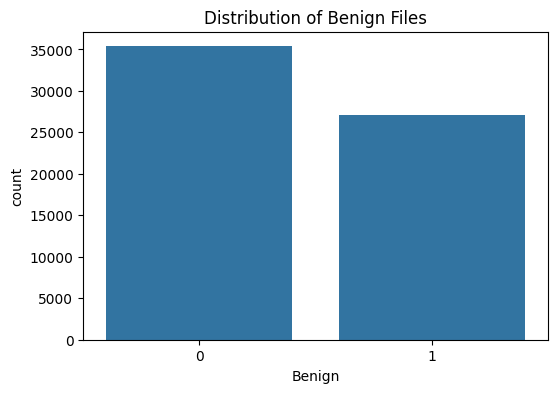

In [9]:
# Analyze the distribution of the 'Benign' label (Malicious or Benign files)
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Benign')
plt.title('Distribution of Benign Files')
plt.show()

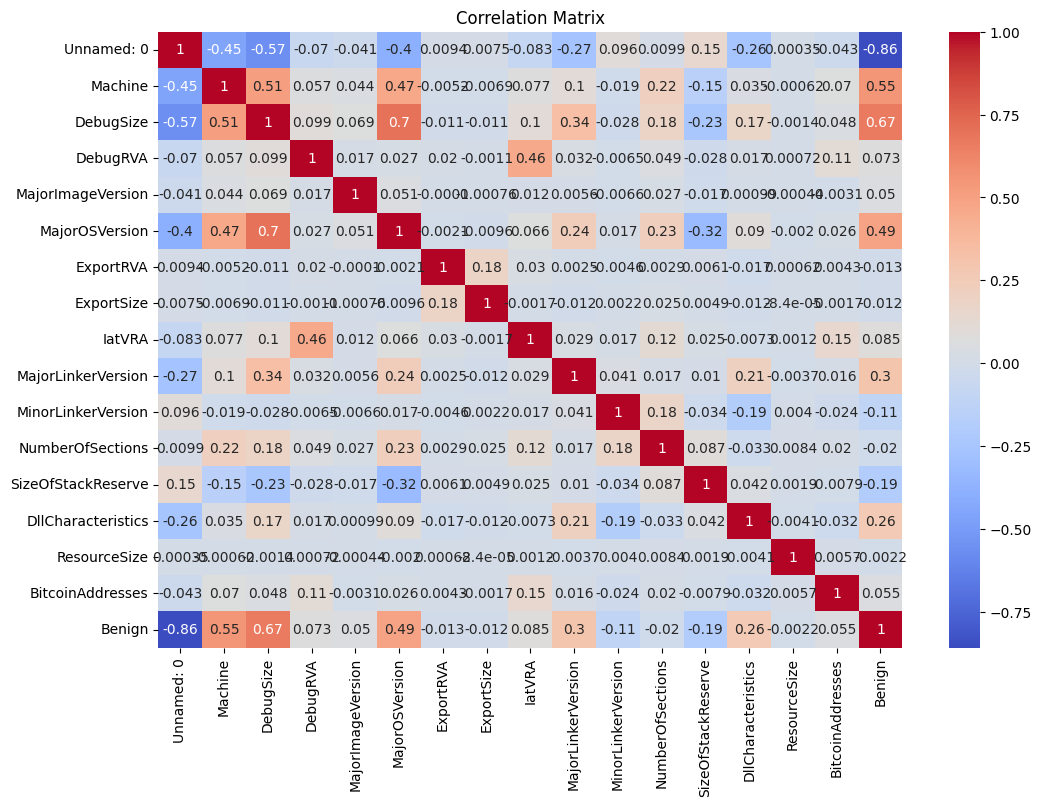

In [10]:
# Analyze correlations between numeric columns
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

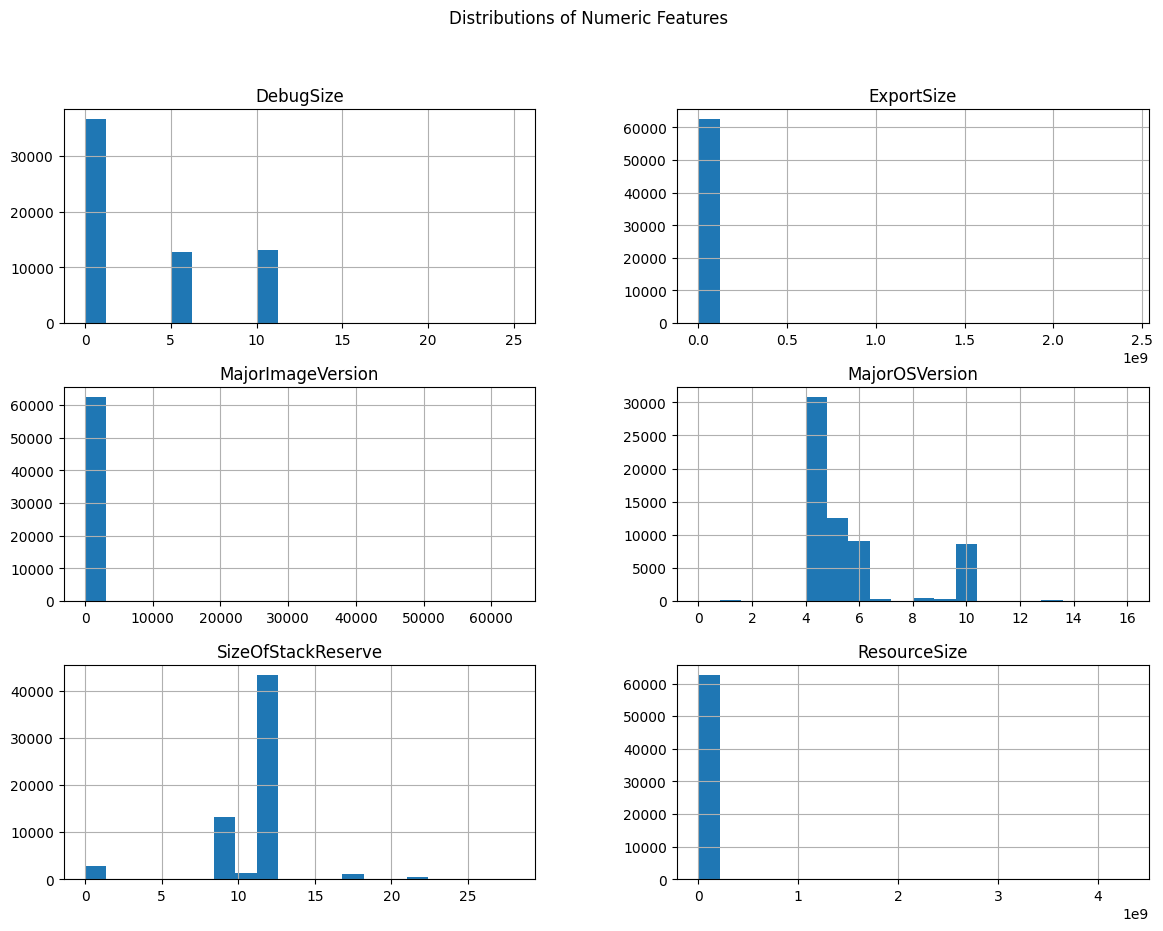

In [11]:
#Distribution of key numeric columns
numeric_columns = ['DebugSize', 'ExportSize', 'MajorImageVersion', 'MajorOSVersion', 'SizeOfStackReserve', 'ResourceSize']
df[numeric_columns].hist(bins=20, figsize=(14,10))
plt.suptitle('Distributions of Numeric Features')
plt.show()

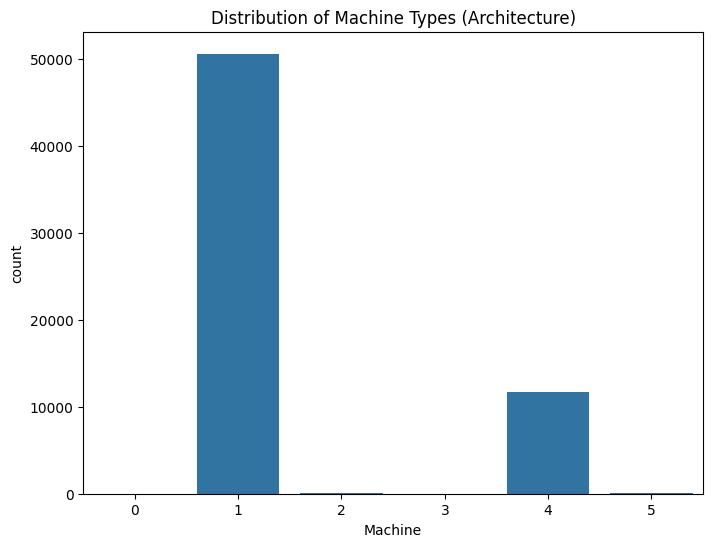

In [12]:
# Analyze distribution of Machine types (architecture)
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='Machine')
plt.title('Distribution of Machine Types (Architecture)')
plt.show()

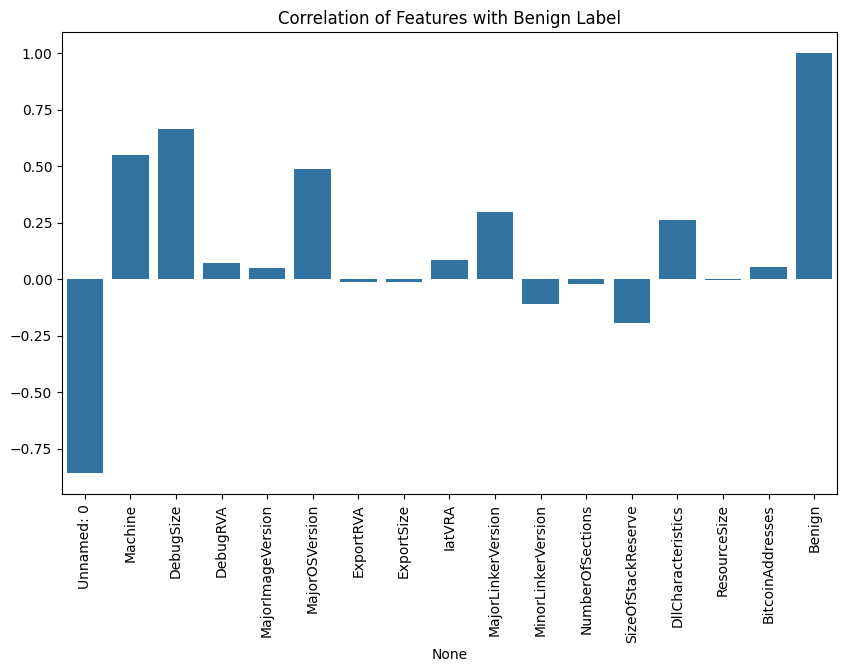

In [13]:
# Correlation of features with the 'Benign' label
plt.figure(figsize=(10,6))
sns.barplot(x=df.corr()['Benign'].index, y=df.corr()['Benign'].values)
plt.xticks(rotation=90)
plt.title('Correlation of Features with Benign Label')
plt.show()

### Transforming Dataset into chunks for training models

In [14]:
# Transorming dataset into subset
df_subset = df.iloc[5000:55000, :]

# Display the shape of the combined dataset to verify
print("Combined dataset shape:", df_subset.shape)

Combined dataset shape: (50000, 17)


In [15]:
# Transform into Lists:
X = df_subset.iloc[:, 1:-1].values
y = df_subset.iloc[:, -1].values
print("The features (Machine ... Bitcoin@) : ")
print(X)
print("Target vector (Benign) : ")
print(y)


The features (Machine ... Bitcoin@) : 
[[      4       6   73728 ...       0       0       0]
 [      4       6 1052672 ...       0       0       0]
 [      4       6 1343488 ...       0       0       0]
 ...
 [      1       0       0 ...       0    4096       0]
 [      1       0       0 ...       0  154488       0]
 [      1       0       0 ...   33088   19708       0]]
Target vector (Benign) : 
[1 1 1 ... 0 0 0]


In [16]:
# Split data into training and testing sets
# 20% testing and 80% train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
# Checking the shape of the training and test sets
print('Shape of the training input data:', X_train.shape)
print('Shape of the training output data:', y_train.shape)
print('Shape of the test input data:', X_test.shape)
print('Shape of the test output data:', y_test.shape)

Shape of the training input data: (40000, 15)
Shape of the training output data: (40000,)
Shape of the test input data: (10000, 15)
Shape of the test output data: (10000,)


## Support Vector Machine

In [18]:
# Create a Support Vector Machine (SVM) Classifier
svm = SVC(kernel='rbf', random_state=0)

In [19]:
# Fit the SVM Classifier to the training data
svm.fit(X_train, y_train)
# Predict the classes of the testing set using SVM
y_pred_svm = svm.predict(X_test)
# Print the accuracy of the model
svm_accuracy = svm.score(X_test, y_test)
print("Accuracy:", svm_accuracy)

Accuracy: 0.5994


In [20]:
!pip install joblib
# Save the trained model to a file
svm_filename = 'svm_classifier_model'
import joblib
joblib.dump(svm, svm_filename)

print(f"Model saved to {svm_filename}")

Model saved to svm_classifier_model


Confusion Matrix for Support Vector Machine:
[[5574   22]
 [3984  420]]


<Figure size 640x480 with 0 Axes>

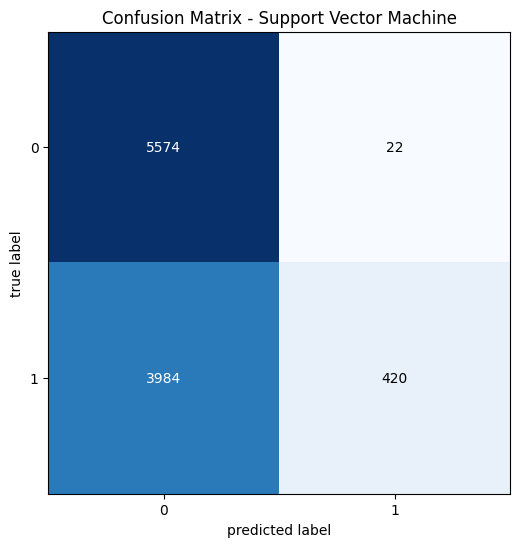

In [21]:
# Confusion matrix and analysis for Support Vector Machine
cm_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix for Support Vector Machine:")
print(cm_svm)
plt.figure()
plot_confusion_matrix(cm_svm, figsize=(8, 6))
plt.title("Confusion Matrix - Support Vector Machine")
plt.show()

## XGBoost Classifier

In [25]:
#Create the XGBoost Classifier
xgboost = XGBClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score( xgboost, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# Save the accuracy as xg_boost_accuracy (mean of cross-validation scores)
xg_boost_accuracy = mean(n_scores)

# Report the performance
print('Accuracy: %.3f (%.3f)' % (xg_boost_accuracy, std(n_scores)))

Accuracy: 0.996 (0.001)


In [24]:
# fit the model on the whole dataset
xgboost.fit(X_train, y_train)
y_pred_xg = xgboost.predict(X_test)

In [26]:
# Save the trained model to a file
xgboost_filename = 'XGBoost_classifier_model'
import joblib
joblib.dump(xgboost, xgboost_filename)

print(f"Model saved to {xgboost_filename}")

Model saved to XGBoost_classifier_model


Confusion Matrix for XGBoost Classifier:
[[5577   19]
 [  22 4382]]


<Figure size 640x480 with 0 Axes>

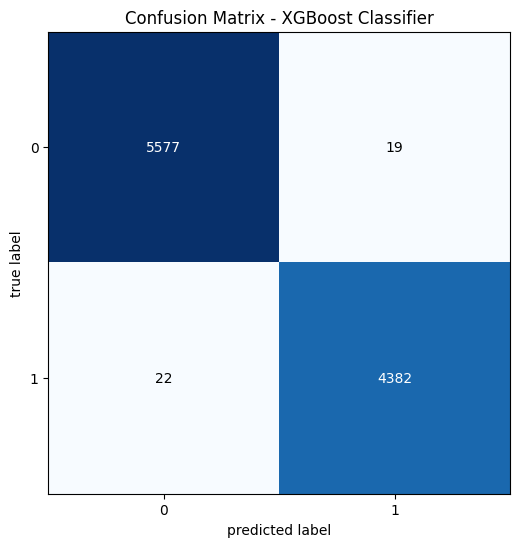

In [27]:
# Confusion matrix and analysis for XGBoost Classifier
cm_xg = confusion_matrix(y_test, y_pred_xg)
print("Confusion Matrix for XGBoost Classifier:")
print(cm_xg)
plt.figure()
plot_confusion_matrix(cm_xg, figsize=(8, 6))
plt.title("Confusion Matrix - XGBoost Classifier")
plt.show()

## Random Forest Classifier

In [29]:
# Create a Random Forest Classifier with 300 trees
rf = RandomForestClassifier(n_estimators=300,random_state=0)

# Fit the Random Forest Classifier to the training data
rf.fit(X_train, y_train)

# Predict the classes of the testing set
y_pred_rf = rf.predict(X_test)

# Print the accuracy of the model
rf_accuracy = rf.score(X_test, y_test)
print("Accuracy:", rf_accuracy)

Accuracy: 0.9965


In [30]:
# Save the trained model to a file
rf_filename = 'RandomForest_classifier_model'
import joblib
joblib.dump(rf, rf_filename)

print(f"Model saved to {rf_filename}")

Model saved to RandomForest_classifier_model


Confusion Matrix for Random Forest Classifier:
[[5580   16]
 [  19 4385]]


<Figure size 640x480 with 0 Axes>

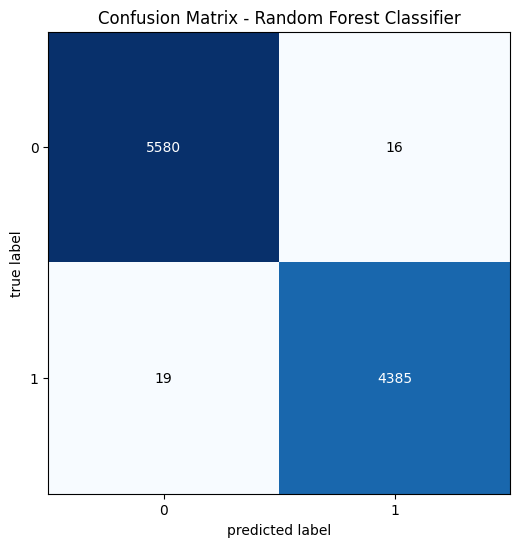

In [32]:
# Confusion matrix and analysis for Random Forest Classifier
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix for Random Forest Classifier:")
print(cm_rf)
plt.figure()
plot_confusion_matrix(cm_rf, figsize=(8, 6))
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

## Multilayer Percepton

In [33]:
# Create an MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=0)
# Fit the ANN Classifier to the training data
mlp.fit(X_train, y_train)
# Predict the classes of the testing set using ANN
y_pred_mlp = mlp.predict(X_test)
# Print the accuracy of the model
mlp_accuracy = mlp.score(X_test, y_test)
print("Accuracy:",mlp_accuracy)

Accuracy: 0.8382


In [35]:
# Save the trained model to a file
mlp_filename = 'MLPclassifier_model'
import joblib
joblib.dump(mlp, mlp_filename)

print(f"Model saved to {mlp_filename}")

Model saved to MLPclassifier_model


Confusion Matrix for Artificial Neural Network:
[[4623  973]
 [ 645 3759]]


<Figure size 640x480 with 0 Axes>

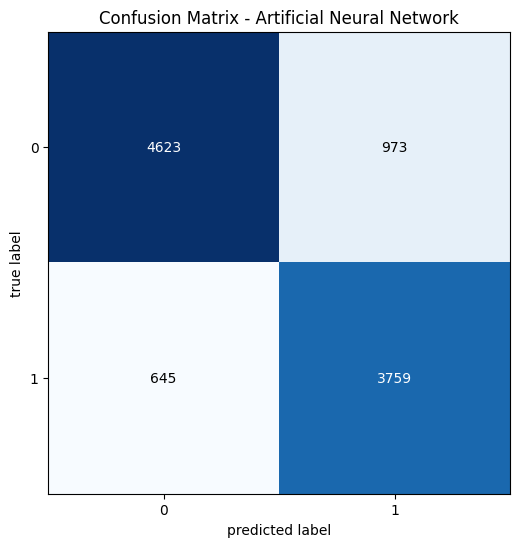

In [37]:
# Confusion matrix and analysis for Artificial Neural Network
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
print("Confusion Matrix for Artificial Neural Network:")
print(cm_mlp)
plt.figure()
plot_confusion_matrix(cm_mlp, figsize=(8, 6))
plt.title("Confusion Matrix - Artificial Neural Network")
plt.show()

## Comparsion of Models

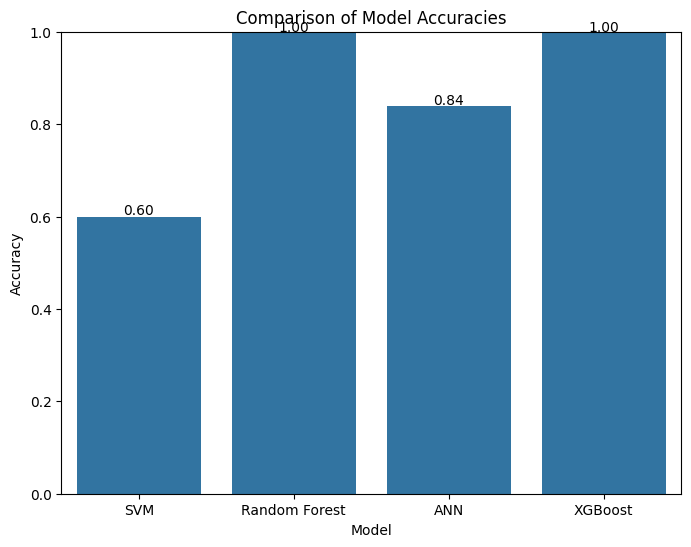

In [38]:
# Store model names and their respective accuracies
model_names = ['SVM', 'Random Forest', 'ANN', 'XGBoost']
accuracies = [svm_accuracy, rf_accuracy, mlp_accuracy, xg_boost_accuracy]

# Plot the accuracies
plt.figure(figsize=(8, 6))
sns.barplot(x=model_names, y=accuracies)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')

# Show exact accuracy values on top of each bar
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f'{acc:.2f}', ha='center')

# Display the plot
plt.ylim(0, 1)  # Adjust y-axis from 0 to 1
plt.show()

## Testing Saved Models on Unseen Dataset

In [39]:
# Select rows from 1 to 5000
df_first_part = df.iloc[:5000, :]

# Select rows from 55001 to the end
df_second_part = df.iloc[55000:, :]

# Combine the two parts into one dataframe
df_combined = pd.concat([df_first_part, df_second_part])

# Display the shape of the combined dataset to verify
print("Combined dataset shape:", df_combined.shape)

Combined dataset shape: (12485, 17)


In [40]:
# Transform into features and target
X_test_combined = df_combined.iloc[:, 1:-1].values
y_test_combined = df_combined.iloc[:, -1].values
# Print to verify
print("The features (Machine ... BitcoinAddresses) : ")
print(X_test_combined)
print("Target vector (Benign) : ")
print(y_test_combined)

The features (Machine ... BitcoinAddresses) : 
[[     1      0      0 ...  34112    672      0]
 [     4     11 121728 ...  16864   1024      0]
 [     1      0      0 ...  34112    672      0]
 ...
 [     1      0      0 ...      0   2364      0]
 [     1      0      0 ...      0 130296      0]
 [     1      0      0 ...      0   6912      0]]
Target vector (Benign) : 
[1 1 1 ... 0 0 0]


### Testing XGBoost Classifier

In [45]:
# Load the saved model
model_filename = 'XGBoost_classifier_model'
loaded_model = joblib.load(model_filename)

# fit the model
loaded_model.fit(X_test_combined, y_test_combined)

# Predict using the loaded model
y_pred_test = loaded_model.predict(X_test_combined)

# Print the predictions and accuracy
print("Predictions on test data:", y_pred_test)
print("Accuracy on test data:", loaded_model.score(X_test_combined, y_test_combined))

Predictions on test data: [1 1 1 ... 0 0 0]
Accuracy on test data: 0.999199038846616


## Testing RandomForest Classifier

In [46]:
# Load the saved model
model_filename = 'RandomForest_classifier_model'
loaded_model = joblib.load(model_filename)

# fit the model
loaded_model.fit(X_test_combined, y_test_combined)

# Predict using the loaded model
y_pred_test = loaded_model.predict(X_test_combined)

# Print the predictions and accuracy
print("Predictions on test data:", y_pred_test)
print("Accuracy on test data:", loaded_model.score(X_test_combined, y_test_combined))

Predictions on test data: [1 1 1 ... 0 0 0]
Accuracy on test data: 0.9996796155386464
